In [ ]:
!pip install --upgrade pip
!pip install datasets transformers torch torchvision torchaudio requests "urllib3<2" scikit-learn matplotlib

In [2]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
x = torch.ones(1).to(device)
print(x)

tensor([1.], device='mps:0')


In [ ]:
from datasets import load_dataset

def load_data():
    d_types = ['train','test','validation']
    datasets = []
    for d in d_types:
        datasets.append(load_dataset(
            'trpakov/chest-xray-classification',
            'full',
            split=d,
        ))
    return datasets

dataset_train, dataset_test, dataset_valid = load_data()
dataset_train


In [4]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['labels']))
labels = dataset_train.features['labels'].names
num_classes, labels

(2, ['PNEUMONIA', 'NORMAL'])

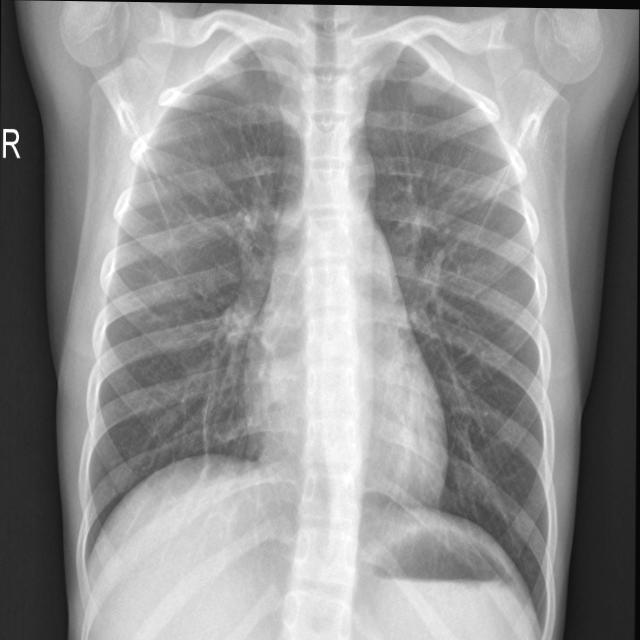

In [5]:
dataset_train[0]['image']

In [ ]:
from transformers import ViTFeatureExtractor
from transformers import TrainingArguments
from transformers import ViTForImageClassification

# import feature extraction model
model_id = 'google/vit-base-patch16-224-in21k'

feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)
model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=len(labels)
).to(device)

In [7]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['labels'] = batch['labels']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)
# ... and the validation dataset
prepared_valid = dataset_valid.with_transform(preprocess)


In [8]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )


/var/folders/l9/h_b80cd93jxgk255znsvsxn40000gn/T/ipykernel_30852/1389652664.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
from transformers import Trainer

# training the model
training_args = TrainingArguments(
  output_dir="./vit_model",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=6,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  optim='adamw_torch',
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

train_results = trainer.train(resume_from_checkpoint=True)
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

In [138]:
# evaluate with validation
metrics = trainer.evaluate(prepared_valid)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


100%|██████████| 146/146 [01:09<00:00,  2.09it/s]

***** eval metrics *****
  epoch                   =        6.0
  eval_accuracy           =      0.976
  eval_loss               =     0.1138
  eval_runtime            = 0:01:10.46
  eval_samples_per_second =     16.534
  eval_steps_per_second   =      2.072


Text(0.5, 1.0, 'ViT: Loss over train steps')

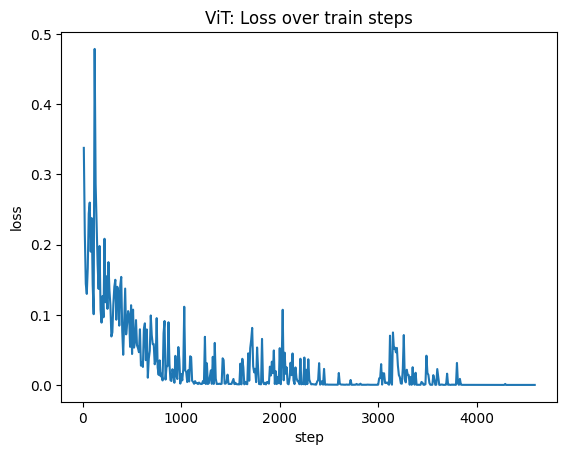

In [149]:
from matplotlib import pyplot as plt

x = [log['step'] for log in trainer.state.log_history if 'loss' in log]
y = [log['loss'] for log in trainer.state.log_history if 'loss' in log]


# y axis is loss
# x axis is step
plt.plot(x, y)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('ViT: Loss over train steps')


In [15]:
# fine tuned model
# import our fine-tuned model
model_name_or_path = './vit_model'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)


In [12]:
# test on patients with pneumonia
a = [m for m in dataset_valid if m['labels'] == 0]

def predict(image):
    inputs = feature_extractor_finetuned(image["image"], return_tensors="pt")
    # extract the actual label of the first image of the testing dataset
    actual_label = image["labels"]

    with torch.no_grad():
        logits = model_finetuned(**inputs).logits

    predicted_label = logits.argmax(-1).item()
    if predicted_label == actual_label:
        return True
    else:
        return False


In [13]:
count = 0
for img in a:
    if predict(img):
        count += 1
print(f"Accuracy: {count/len(a)}")

Accuracy: 0.9965156794425087
